In [121]:
import os, glob, re, cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import random

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers, activations, optimizers, losses, metrics, initializers
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions

In [129]:
dir_path = "data/archive/Dataset_BUSI_with_GT/"
IMAGE_SHAPE = (224, 224)

In [133]:
# create prepare_image method
# used to preprocess the image for efficientNet model
def prepare_image(file, file2 = None, beta = False):
    img1 = image.load_img(file, target_size=IMAGE_SHAPE)
    img_array = image.img_to_array(img1)

    if file2:

        img2 = image.load_img(file2, target_size=IMAGE_SHAPE)
        img_array2 = image.img_to_array(img2)

        alpa = 0
        if beta:
            alpha = np.random.beta(0.2, 0.2, 1)
        else:
            alpha = random.random()

        print(f"Alpha = {alpha}")

        img_array = 0.5 * img_array + 0.5 * img_array2

    return tf.keras.applications.efficientnet.preprocess_input (img_array)

In [134]:
directories = os.listdir(dir_path) # read the folders

files = [] # save all images for each folder
labels = [] # set for each image the name of it

# read files for each directory
for folder in directories:
    
    fileList = glob.glob(f'{dir_path}/{folder}/*')
    labels.extend([folder for _ in fileList])
    files.extend(fileList)

len(files), len(labels)

(1578, 1578)

In [135]:
print(labels)

['benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign',

In [6]:
# create two lists to hold only non-mask images and label for each one
selected_files = []
selected_labels = []

for file, label in zip(files, labels):
    if 'mask' not in file:
        selected_files.append(file)
        selected_labels.append(label)

    
len(selected_files), len(selected_labels)

(780, 780)

Alpha = [0.04991617]


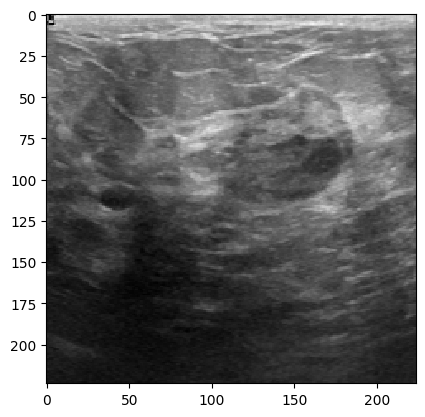

In [144]:
#TEST MIXUP

test_image = prepare_image(selected_files[77], selected_files[79], True)
test_image = tf.keras.utils.array_to_img(test_image)

plt.imshow(test_image, interpolation='nearest')

In [145]:
# the dictionary holds list of images and for each one has its target/label
images = {
    'image': [], 
    'target': []
}

print('Preparing the image...')

for file, label in zip(selected_files, selected_labels):
    images['image'].append(prepare_image(file))
    images['target'].append(label)

print('Finished.')

Preparing the image...
Finished.


In [146]:
# convert lists to arrays 
images['image'] = np.array(images['image'])
images['target'] = np.array(images['target'])

# encode the target
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

images['target'] = le.fit_transform(images['target'])

classes = le.classes_ # get the classes for each target
print(f'the target classes are: {classes}')

the target classes are: ['benign' 'malignant' 'normal']


In [147]:
x_train, x_test, y_train, y_test = train_test_split(images['image'], images['target'], test_size=.10)

x_train.shape, x_test.shape, y_train.shape, y_test.shape 

((702, 224, 224, 3), (78, 224, 224, 3), (702,), (78,))

In [148]:
# The code is creating a ResNet152V2 model with pre-trained weights from the ImageNet dataset. 
# The base model is frozen, meaning its weights will not be updated during training. 
# The code then appends additional layers on top of the base model for transfer learning.

from tensorflow.keras.applications import resnet_v2
base_model = resnet_v2.ResNet152V2(
    include_top=False,
    weights='imagenet',
    input_shape=(*IMAGE_SHAPE, 3),
    classes=3)

# Freeze the base_model
base_model.trainable = False

# append my own layers on the top of the model for Transfer Learning
x = base_model.output

# 1st conv block
x = layers.Conv2D(256, 3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.GlobalAveragePooling2D(keepdims = True)(x)

# 2nd conv block
x = layers.Conv2D(128, 3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.GlobalAveragePooling2D(keepdims = True)(x)

# 1st FC layer
x = layers.Flatten()(x) 
x = layers.Dense(64)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

# 2nd FC layer
x = layers.Dense(32, activation = 'relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(.2)(x)

x = layers.Dense(3, 'softmax')(x)

incept_model = keras.models.Model(inputs = base_model.input, outputs = x)

# compile the model
incept_model.compile(optimizer=optimizers.RMSprop(.001), loss = losses.sparse_categorical_crossentropy, metrics= [metrics.SparseCategoricalAccuracy()])

# incept_model.summary()

In [152]:
EPOCHS = 2
# Trains and returns incept_model. fit ( x_train y_train )
earlyStop = keras.callbacks.EarlyStopping(patience=60) 
best_model = keras.callbacks.ModelCheckpoint(filepath='best_model.h5', save_best_only=True) 

with tf.device('/gpu:0'):
    history = incept_model.fit(x_train, y_train, batch_size=32, epochs=EPOCHS, validation_data=(x_test, y_test), callbacks=[earlyStop, best_model]) 

Epoch 1/2
22/22 [==============================] - 56s 3s/step - loss: 1.0383 - sparse_categorical_accuracy: 0.5570 - val_loss: 1.0829 - val_sparse_categorical_accuracy: 0.3077
Epoch 2/2
22/22 [==============================] - 55s 2s/step - loss: 1.0027 - sparse_categorical_accuracy: 0.5470 - val_loss: 0.9645 - val_sparse_categorical_accuracy: 0.6026


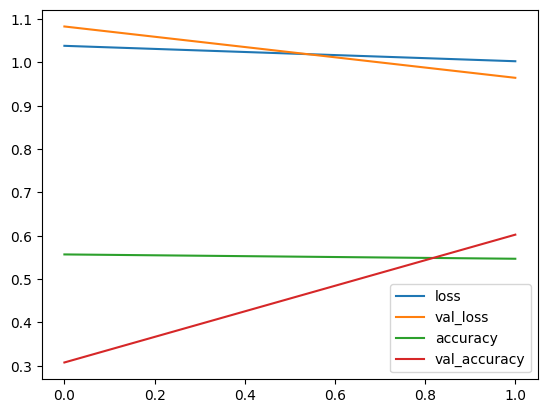

In [153]:
hist = history.history

plt.plot(hist['loss'], label=  'loss')
plt.plot(hist['val_loss'], label = 'val_loss')
plt.plot(hist['sparse_categorical_accuracy'], label='accuracy')
plt.plot(hist['val_sparse_categorical_accuracy'], label='val_accuracy')
plt.legend()

In [154]:
incept_model.evaluate(x=x_test, y = y_test, batch_size=32, verbose=1)

3/3 [==============================] - 5s 2s/step - loss: 0.9645 - sparse_categorical_accuracy: 0.6026


[0.9644607305526733, 0.6025640964508057]

In [155]:
# open train the last 100 layers
for layer in incept_model.layers[720:]:
    layer.trainable = True
    
# compile the model with new optimizer and lr=.0001
incept_model.compile(optimizer=optimizers.RMSprop(.0001), loss = losses.sparse_categorical_crossentropy, metrics=[metrics.SparseCategoricalAccuracy()])

# incept_model.summary()

In [156]:
earlyStop = keras.callbacks.EarlyStopping(patience=60) 
best_model = keras.callbacks.ModelCheckpoint(filepath='best_model_2.h5', save_best_only=True) 

# load the best weights
# incept_model.set_weights(best_weights)

with tf.device('/gpu:0'):
    history = incept_model.fit(x_train, y_train, batch_size=32, epochs=EPOCHS, validation_data=(x_test, y_test), callbacks=[earlyStop, best_model]) 

Epoch 1/2
22/22 [==============================] - 63s 3s/step - loss: 0.9280 - sparse_categorical_accuracy: 0.5997 - val_loss: 0.9421 - val_sparse_categorical_accuracy: 0.6026
Epoch 2/2
22/22 [==============================] - 54s 2s/step - loss: 0.8812 - sparse_categorical_accuracy: 0.6140 - val_loss: 0.9688 - val_sparse_categorical_accuracy: 0.6026


In [157]:
incept_model.evaluate(x=x_test, y = y_test, batch_size=32, verbose=1)

3/3 [==============================] - 5s 2s/step - loss: 0.9688 - sparse_categorical_accuracy: 0.6026


[0.9688326716423035, 0.6025640964508057]